In [45]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

In [46]:
#Importing data
df = pd.read_csv("Combined_Emot_Data.csv")
df.head()

,unicode,emoji,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,...,Unicode block,le_+,le_-,le_0,sent_score,sent_score_class,upper_error_class,lower_error_class,sent_polar,primary_basic_emot
0,1F308,🌈,0.00,0.28,0.00,0.00,0.69,0.06,0.22,0.33,...,Miscellaneous Symbols and Pictographs,0.582418,0.065934,0.351648,0.516484,Positive,Positive,Positive,Positive,joy
1,1F319,🌙,0.00,0.31,0.00,0.00,0.25,0.00,0.06,0.25,...,Miscellaneous Symbols and Pictographs,0.655738,0.065574,0.278689,0.590164,Positive,Positive,Positive,Positive,anticipation
2,1F31A,🌚,0.06,0.08,0.17,0.06,0.42,0.19,0.06,0.11,...,Miscellaneous Symbols and Pictographs,0.622517,0.158940,0.218543,0.463576,Positive,Positive,Positive,Positive,joy
3,1F31E,🌞,0.00,0.22,0.00,0.00,0.78,0.00,0.11,0.22,...,Miscellaneous Symbols and Pictographs,0.581818,0.024242,0.393939,0.557576,Positive,Positive,Positive,Positive,joy
4,1F31F,🌟,0.00,0.28,0.00,0.00,0.53,0.00,0.25,0.31,...,Miscellaneous Symbols and Pictographs,0.386139,0.059406,0.554455,0.326733,Positive,Positive,Positive,Positive,joy


In [47]:
#List columns
df.columns

Index(['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'le_+',
       'le_-', 'le_0', 'sent_score', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot'],
      dtype='object')

In [48]:
#Drop cols not needed for this work
df = df.drop(columns=['unicode', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot'])
df.head()

,emoji,le_+,le_-,le_0,sent_score
0,🌈,0.582418,0.065934,0.351648,0.516484
1,🌙,0.655738,0.065574,0.278689,0.590164
2,🌚,0.622517,0.158940,0.218543,0.463576
3,🌞,0.581818,0.024242,0.393939,0.557576
4,🌟,0.386139,0.059406,0.554455,0.326733


In [49]:
#Import emoji lexicon

#Create lists for emojis and vectors
emoji_list = []
vector_list = []

#Extract contents into lists
with open('emoji2vec.txt', 'r', encoding='utf-8') as file:
    for idx, line in enumerate(file):
        if idx == 0:
            continue  # Skip the first line
        tokens = line.strip().split()
        emoji = tokens[0]
        vector = [float(v) for v in tokens[1:]]
        emoji_list.append(emoji)
        vector_list.append(vector)

#Confirm contents is all there
len(emoji_list), len(vector_list)

(1661, 1661)

In [50]:
#Convert list of emojis to a df
df_final_dim = pd.DataFrame(emoji_list, columns=['emoji'])
df_final_dim.head()

,emoji
0,🇸🇰
1,👔
2,🌀
3,🚾
4,👹


In [51]:
#Check shape
df_final_dim.shape

(1661, 1)

In [52]:
#Add in all true values from the human annotated dataset

#Create empty columns to store the data for each emotion
df_final_dim['le_+'] = np.nan
df_final_dim['le_-'] = np.nan
df_final_dim['le_0'] = np.nan
df_final_dim['sent_score'] = np.nan

df_final_dim.head()

,emoji,le_+,le_-,le_0,sent_score
0,🇸🇰,NaN,NaN,NaN,NaN
1,👔,NaN,NaN,NaN,NaN
2,🌀,NaN,NaN,NaN,NaN
3,🚾,NaN,NaN,NaN,NaN
4,👹,NaN,NaN,NaN,NaN


In [53]:
#Fill in values from the original df into the new df

#Define categories for classifications
classes = ['le_+', 'le_-', 'le_0', 'sent_score']

#Set emoji column as the index for both dfs
df.set_index('emoji', inplace=True)
df_final_dim.set_index('emoji', inplace=True)

#Populate data into the new df
df_final_dim.update(df[classes])

#Reset the index
df_final_dim.reset_index(inplace=True)
df.reset_index(inplace=True)

df_final_dim.isnull().sum()

emoji            0
le_+          1529
le_-          1529
le_0          1529
sent_score    1529
dtype: int64

In [54]:
#Importing df
df_basic = pd.read_csv("final_basic_emotions.csv")
df_basic.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
0,👔,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317
1,🌀,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603
2,🚾,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127
3,👹,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623
4,🚻,0.112900,0.134558,0.123245,0.123930,0.122332,0.091016,0.137306,0.149267


In [55]:
#Create empty columns to store the data for each emotion
df_final_dim['anger'] = np.nan
df_final_dim['joy'] = np.nan
df_final_dim['sadness'] = np.nan
df_final_dim['fear'] = np.nan
df_final_dim['surprise'] = np.nan
df_final_dim['disgust'] = np.nan
df_final_dim['anticipation'] = np.nan
df_final_dim['trust'] = np.nan

df_final_dim.head()

,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
0,🇸🇰,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,👔,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,🌀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,🚾,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,👹,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#Add data into the dimensional theory df

#Create a list of basic emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

#Set emoji column as the index for both dfs
#df_basic.set_index('emoji', inplace=True)
#df_final_dim.set_index('emoji', inplace=True)

#Populate data into the new df
df_final_dim.update(df_basic[emotions])

#Reset the index
df_final_dim.reset_index(inplace=True)
df_basic.reset_index(inplace=True)

df_final_dim.isnull().sum()

index              0
emoji              0
le_+            1529
le_-            1529
le_0            1529
sent_score      1529
anger              1
joy                1
sadness            1
fear               1
surprise           1
disgust            1
anticipation       1
trust              1
dtype: int64

In [57]:
#Visualise the data min, max, mean distributions
df_final_dim.describe()

,index,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
count,1661.000000,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,830.000000,0.509553,0.190934,0.299513,0.318619,0.122087,0.137911,0.118356,0.119690,0.122378,0.100261,0.136967,0.140763
std,479.633714,0.167632,0.170015,0.115376,0.317332,0.008426,0.012712,0.010683,0.007993,0.003601,0.013490,0.003825,0.010681
min,0.000000,0.164835,0.008403,0.108037,-0.396501,0.092320,0.091324,0.084781,0.083941,0.095694,-0.023180,0.104046,0.099404
25%,415.000000,0.360482,0.056537,0.220781,0.115110,0.117790,0.131688,0.112994,0.115207,0.122332,0.093483,0.137242,0.134871
50%,830.000000,0.535984,0.123151,0.272018,0.416946,0.123082,0.137438,0.116838,0.119269,0.122332,0.100440,0.137283,0.140722
75%,1245.000000,0.634270,0.294019,0.326526,0.561786,0.126793,0.143553,0.121171,0.123117,0.122332,0.107426,0.137394,0.147027
max,1660.000000,0.798969,0.600583,0.734940,0.778351,0.194553,0.203568,0.197044,0.179909,0.168216,0.173729,0.173871,0.177931


In [58]:
#Scale the basic emotions as per previous method
df_final_dim['total_bt'] = df_final_dim['anger'] + df_final_dim['anticipation'] + df_final_dim['disgust'] + df_final_dim['fear'] + df_final_dim['joy'] + df_final_dim['sadness'] + df_final_dim['surprise'] + df_final_dim['trust']
df_final_dim['total_prescale_bt'] = df_final_dim['total_bt']

#Scale le+ and le- as per previous method
df_final_dim['total_dt'] = df_final_dim['le_+'] + df_final_dim['le_-']
df_final_dim['total_prescale_dt'] = df_final_dim['total_dt']

df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317,0.999676,0.999676,NaN,NaN
1,1,👔,NaN,NaN,NaN,NaN,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603,0.999552,0.999552,NaN,NaN
2,2,🌀,NaN,NaN,NaN,NaN,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127,1.011926,1.011926,NaN,NaN
3,3,🚾,NaN,NaN,NaN,NaN,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623,1.036502,1.036502,NaN,NaN
4,4,👹,NaN,NaN,NaN,NaN,0.112900,0.134558,0.123245,0.123930,0.122332,0.091016,0.137306,0.149267,0.994555,0.994555,NaN,NaN


In [59]:
#Remove the row that is totally empty
df_final_dim.dropna(subset=['anger'], inplace=True)
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.126262,0.143311,0.104819,0.116589,0.122332,0.107721,0.137325,0.141317,0.999676,0.999676,NaN,NaN
1,1,👔,NaN,NaN,NaN,NaN,0.125151,0.127141,0.126822,0.137144,0.122332,0.082033,0.136325,0.142603,0.999552,0.999552,NaN,NaN
2,2,🌀,NaN,NaN,NaN,NaN,0.129196,0.140521,0.116989,0.122374,0.122332,0.115062,0.136324,0.129127,1.011926,1.011926,NaN,NaN
3,3,🚾,NaN,NaN,NaN,NaN,0.114631,0.126279,0.153117,0.145137,0.122332,0.078083,0.137299,0.159623,1.036502,1.036502,NaN,NaN
4,4,👹,NaN,NaN,NaN,NaN,0.112900,0.134558,0.123245,0.123930,0.122332,0.091016,0.137306,0.149267,0.994555,0.994555,NaN,NaN


In [60]:
#Scale primary categories as per previous method

scale_cols=['total_bt', 'total_dt', 'sent_score', 'le_0']

#Apply min max scaler to relevant columns
def scaling():
    scaler = MinMaxScaler(feature_range=(0.01, 1)) #To avoid re-addition of zero-probabilities
    df_final_dim[scale_cols]=scaler.fit_transform(df_final_dim[scale_cols])
    return df_final_dim

#Apply the function
df_final_dim = scaling()

#Verify it worked
df_final_dim.describe()

,index,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_prescale_bt,total_dt,total_prescale_dt
count,1660.000000,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000,132.000000
mean,829.500000,0.509553,0.190934,0.312378,0.612603,0.122087,0.137911,0.118356,0.119690,0.122378,0.100261,0.136967,0.140763,0.585436,0.998411,0.697622,0.700487
std,479.345039,0.167632,0.170015,0.182201,0.267403,0.008426,0.012712,0.010683,0.007993,0.003601,0.013490,0.003825,0.010681,0.055065,0.015700,0.182201,0.115376
min,0.000000,0.164835,0.008403,0.010000,0.010000,0.092320,0.091324,0.084781,0.083941,0.095694,-0.023180,0.104046,0.099404,0.010000,0.834339,0.010000,0.265060
25%,414.750000,0.360482,0.056537,0.188045,0.441114,0.117790,0.131688,0.112994,0.115207,0.122332,0.093483,0.137242,0.134871,0.556637,0.990200,0.654964,0.673474
50%,829.500000,0.535984,0.123151,0.268958,0.695459,0.123082,0.137438,0.116838,0.119269,0.122332,0.100440,0.137283,0.140722,0.590159,0.999758,0.741042,0.727982
75%,1244.250000,0.634270,0.294019,0.355036,0.817510,0.126793,0.143553,0.121171,0.123117,0.122332,0.107426,0.137394,0.147027,0.614546,1.006711,0.821955,0.779219
max,1659.000000,0.798969,0.600583,1.000000,1.000000,0.194553,0.203568,0.197044,0.179909,0.168216,0.173729,0.173871,0.177931,1.000000,1.116614,1.000000,0.891963


In [61]:
#Scale subclassifiers within categories-basic emotions

#Determine scaling factor for the row
df_final_dim['scaling_factor'] = df_final_dim['total_prescale_bt'] / df_final_dim['total_bt']

#Scale each basic emotion value using the scaling factor
df_final_dim['anger'] = df_final_dim['anger'] / df_final_dim['scaling_factor']
df_final_dim['anticipation'] = df_final_dim['anticipation'] / df_final_dim['scaling_factor']
df_final_dim['disgust'] = df_final_dim['disgust'] / df_final_dim['scaling_factor']
df_final_dim['fear'] = df_final_dim['fear'] / df_final_dim['scaling_factor']
df_final_dim['joy'] = df_final_dim['joy'] / df_final_dim['scaling_factor']
df_final_dim['sadness'] = df_final_dim['sadness'] / df_final_dim['scaling_factor']
df_final_dim['surprise'] = df_final_dim['surprise'] / df_final_dim['scaling_factor']
df_final_dim['trust'] = df_final_dim['trust'] / df_final_dim['scaling_factor']

#Remove columns that are no longer needed
df_final_dim = df_final_dim.drop(columns=['total_prescale_bt', 'scaling_factor'])

df_final_dim.describe()

,index,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt,total_prescale_dt
count,1660.000000,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000,132.000000
mean,829.500000,0.509553,0.190934,0.312378,0.612603,0.071392,0.080940,0.069454,0.070164,0.071669,0.059040,0.080211,0.082566,0.585436,0.697622,0.700487
std,479.345039,0.167632,0.170015,0.182201,0.267403,0.006620,0.011041,0.009726,0.008030,0.006087,0.010398,0.006767,0.010202,0.055065,0.182201,0.115376
min,0.000000,0.164835,0.008403,0.010000,0.010000,0.002092,0.001128,0.001269,0.001292,0.001466,-0.000278,0.001650,0.001381,0.010000,0.010000,0.265060
25%,414.750000,0.360482,0.056537,0.188045,0.441114,0.067537,0.074921,0.064242,0.065743,0.068252,0.052919,0.076511,0.076540,0.556637,0.654964,0.673474
50%,829.500000,0.535984,0.123151,0.268958,0.695459,0.071736,0.080554,0.068364,0.069729,0.071683,0.059227,0.080328,0.082389,0.590159,0.741042,0.727982
75%,1244.250000,0.634270,0.294019,0.355036,0.817510,0.075181,0.087342,0.072863,0.073918,0.075166,0.065307,0.084187,0.088546,0.614546,0.821955,0.779219
max,1659.000000,0.798969,0.600583,1.000000,1.000000,0.114982,0.143305,0.173443,0.139684,0.109557,0.102675,0.122995,0.157142,1.000000,1.000000,0.891963


In [62]:
#Repeat for dimensional theory subclassifiers

#Determine scaling factor for the row
df_final_dim['scaling_factor'] = df_final_dim['total_prescale_dt'] / df_final_dim['total_dt']

#Scale each basic emotion value using the scaling factor
df_final_dim['le_+'] = df_final_dim['le_+']/df_final_dim['scaling_factor']

#Remove columns that are no longer needed
df_final_dim = df_final_dim.drop(columns=['total_prescale_dt', 'scaling_factor'])

#Verify transformations are ok
df_final_dim.describe()

,index,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt
count,1660.000000,132.000000,132.000000,132.000000,132.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,132.000000
mean,829.500000,0.504398,0.190934,0.312378,0.612603,0.071392,0.080940,0.069454,0.070164,0.071669,0.059040,0.080211,0.082566,0.585436,0.697622
std,479.345039,0.195644,0.170015,0.182201,0.267403,0.006620,0.011041,0.009726,0.008030,0.006087,0.010398,0.006767,0.010202,0.055065,0.182201
min,0.000000,0.008333,0.008403,0.010000,0.010000,0.002092,0.001128,0.001269,0.001292,0.001466,-0.000278,0.001650,0.001381,0.010000,0.010000
25%,414.750000,0.352980,0.056537,0.188045,0.441114,0.067537,0.074921,0.064242,0.065743,0.068252,0.052919,0.076511,0.076540,0.556637,0.654964
50%,829.500000,0.507432,0.123151,0.268958,0.695459,0.071736,0.080554,0.068364,0.069729,0.071683,0.059227,0.080328,0.082389,0.590159,0.741042
75%,1244.250000,0.658001,0.294019,0.355036,0.817510,0.075181,0.087342,0.072863,0.073918,0.075166,0.065307,0.084187,0.088546,0.614546,0.821955
max,1659.000000,0.863423,0.600583,1.000000,1.000000,0.114982,0.143305,0.173443,0.139684,0.109557,0.102675,0.122995,0.157142,1.000000,1.000000


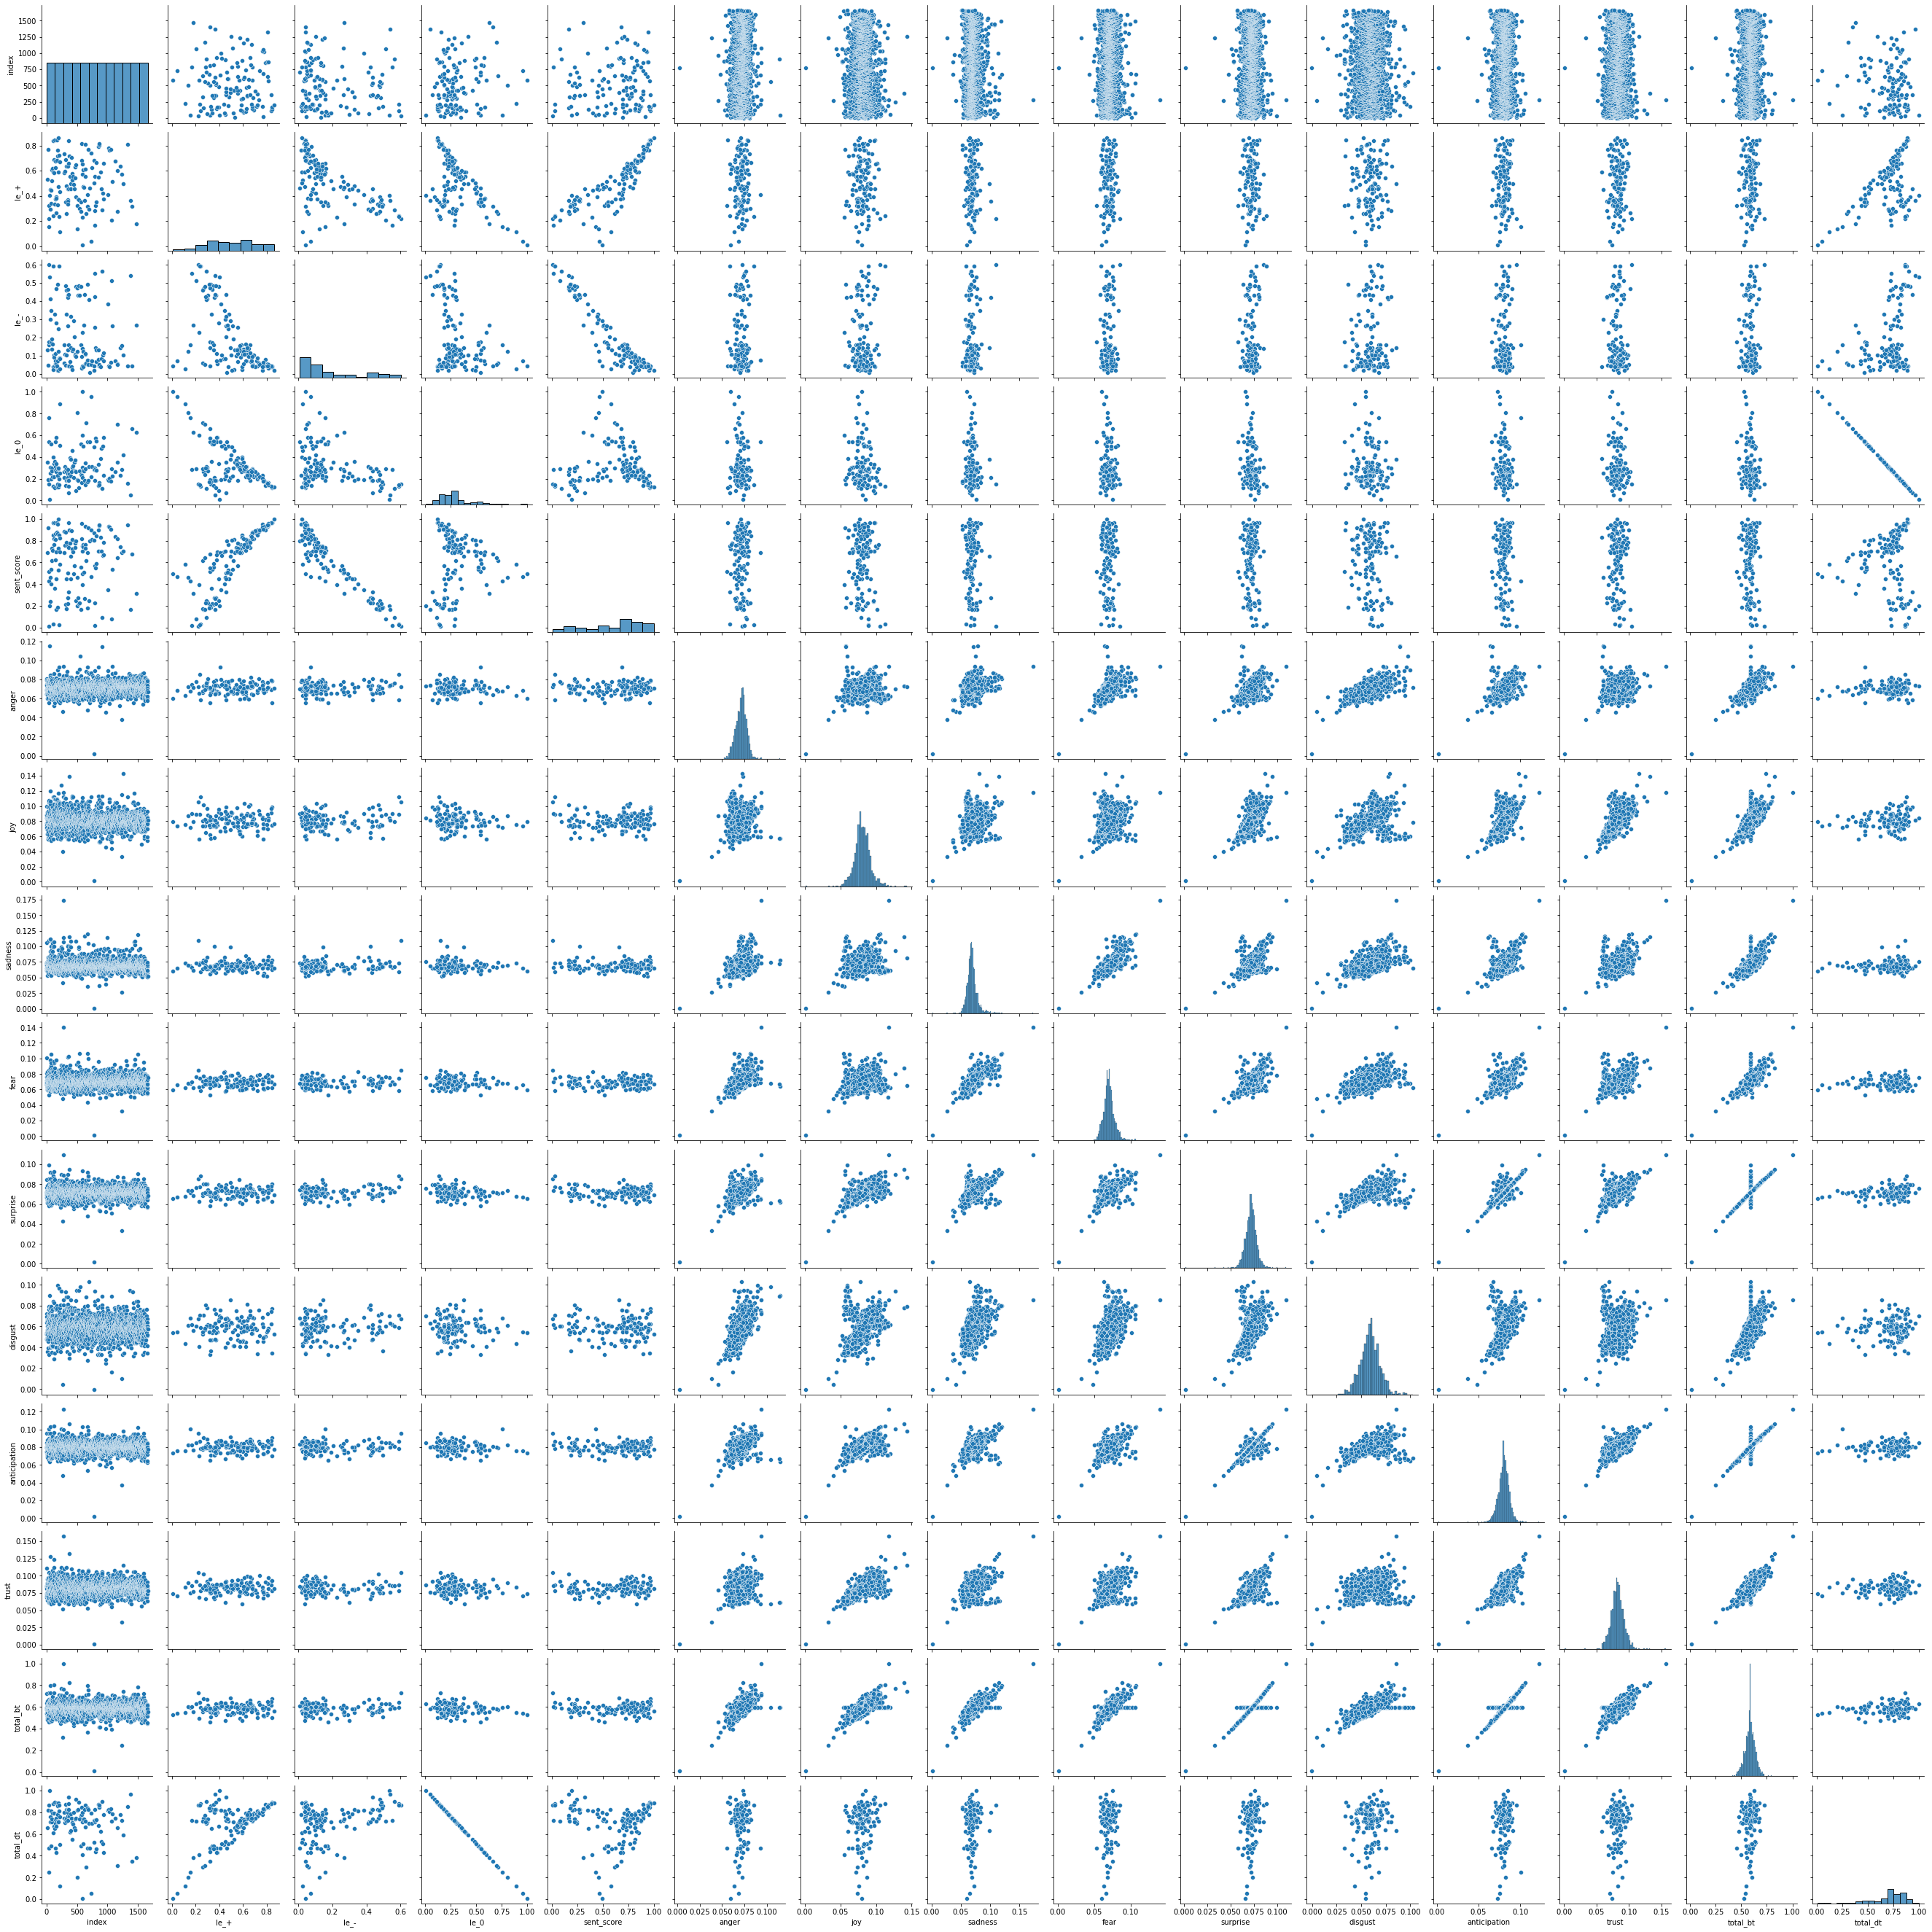

In [63]:
#Create a pairplot
sns.pairplot(df_final_dim)

# Predicting le_+ univariate

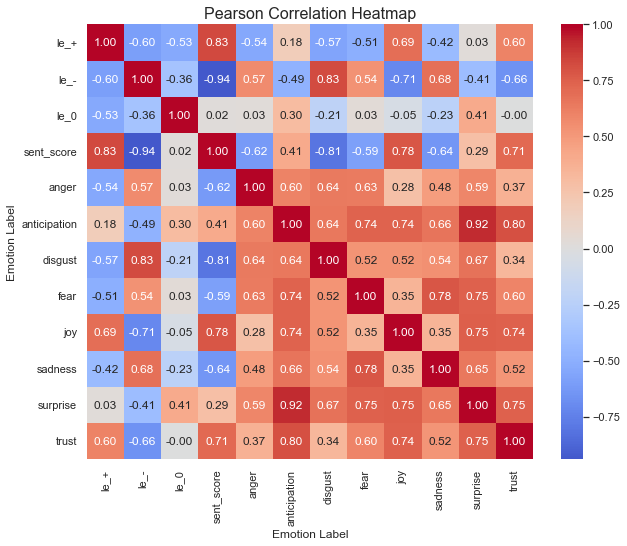

In [62]:
#Create a pearsons correlation plot to aid in dimensionality reduction later on

#Define columns for pearson correlation plot
cols = classes + emotions

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

In [21]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [32]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.09513792005976193
Mean Squared Error (MSE): 0.012735930081260314
R-squared (R2) score: 0.582551111424807


In [33]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.10305748604425073
Mean Squared Error (MSE): 0.017393181877463144
R-squared (R2) score: 0.42989915952689695


In [34]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 0.11880517882853946
Mean Squared Error (MSE): 0.023449309940960256
R-squared (R2) score: 0.23139587684196805


In [35]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.09935470034690418
Mean Squared Error (MSE): 0.014468287204536058
R-squared (R2) score: 0.5257691919958636


In [36]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-07), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.09657313823138859
Mean Squared Error (MSE): 0.013866606976438503
R-squared (R2) score: 0.545490621125454


In [37]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.10121342530327505
Mean Squared Error (MSE): 0.015969684901000068
R-squared (R2) score: 0.4765574896938489


In [63]:
#Remove worst perfoming models from consideration and remove input params with the lowest correlation to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [64]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Mean Absolute Error (MAE): 0.10277659607039347
Mean Squared Error (MSE): 0.01526748865587266
R-squared (R2) score: 0.5562078475245306


In [65]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.08842831406736301
Mean Squared Error (MSE): 0.01254507910943652
R-squared (R2) score: 0.6353422762288827


In [66]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-09), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.09947623015688783
Mean Squared Error (MSE): 0.014037088572901632
R-squared (R2) score: 0.5919728586233056


In [75]:
#Remove worst perfoming models from consideration and keep only highest correlated input variables to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anger', 'joy', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [76]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.09623650797707992
Mean Squared Error (MSE): 0.01384837853448977
R-squared (R2) score: 0.5735674250955223


In [77]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Absolute Error (MAE): 0.09853021707971275
Mean Squared Error (MSE): 0.014062371697153488
R-squared (R2) score: 0.5669779420640343


In [78]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-14), 'n_restarts_optimizer': 1}
Mean Absolute Error (MAE): 0.10474724721097534
Mean Squared Error (MSE): 0.01631584511272899
R-squared (R2) score: 0.4975868239133161


In [88]:
#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_+']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [90]:
#Try stacking models to improve outcomes- linear and non linear

#Linear regression
#Define hypermarams
best_hyperparams_linear = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
#Train the model
linear_model = LinearRegression(**best_hyperparams_linear)
linear_model.fit(X_train, Y_train)
#Test model
linear_pred = linear_model.predict(X_test)

#Random forest performed better than XGBoost so it will be the non linear
#Define hypermarams
best_hyperparams_xgboost = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
#Train the model
xgboost_model = XGBRegressor(**best_hyperparams_xgboost)
xgboost_model.fit(X_train, Y_train)
#Test model
xgboost_pred = xgboost_model.predict(X_test)

#Stack the outcomes
y_pred = (linear_pred + xgboost_pred) / 2

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.1272443996790745
Mean Squared Error (MSE): 0.02217305813650564
R-squared (R2) score: 0.46984371004396697


In [24]:
#Define params for a meta model using the best outcomes for le+

#Define target param
Y = df_final_no_null['le_+']

#Define first set of params
X1 = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y, test_size=0.2)

#Define second set of params
X2 = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y, test_size=0.2)

#Define third set of params
X3 = df_final_no_null[['anger', 'joy', 'trust']]
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y, test_size=0.2)

In [93]:
#Try a meta model architecture using the best outcomes for le+ so far

#Linear regression
#Define hypermarams
best_hyperparams_linear = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
#Train the model
linear_model = LinearRegression(**best_hyperparams_linear)
linear_model.fit(X_train1, Y_train1)
#Test model
linear_pred = linear_model.predict(X_test1)

#Gaussian process regression
best_hyperparams_gaus = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-07), 'n_restarts_optimizer': 5}
#Train the model
gaus_model = GaussianProcessRegressor(**best_hyperparams_gaus)
gaus_model.fit(X_train1, Y_train1)
#Test model
gaus_pred = gaus_model.predict(X_test1)

#Support vector
#Define hypermarams
best_hyperparams_supvec = {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
#Train the model
supvec_model = SVR(**best_hyperparams_supvec)
supvec_model.fit(X_train2, Y_train2)
#Test model
supvec_pred = supvec_model.predict(X_test2)

#Create the meta model
meta_model = RandomForestRegressor()
#Stack predictions
stacked_predictions = np.column_stack((linear_pred, gaus_pred, supvec_pred))
#Train the model
meta_model.fit(stacked_predictions, Y_test)
#Test the model
final_pred = meta_model.predict(stacked_predictions)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.06888280169546288
Mean Squared Error (MSE): 0.007521358197142874
R-squared (R2) score: 0.8201648445298276


In [59]:
#Check effects of altering the meta model architecture- generate all previous tested models

#Linear regression
#Define hypermarams
best_hyperparams_lr = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
#Train the model
lr_model = LinearRegression(**best_hyperparams_lr)
lr_model.fit(X_train1, Y_train1)
#Test model
lr_pred = lr_model.predict(X_test1)

#Random forest regression
#Define hypermarams
best_hyperparams_rf = {'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 25}
#Train the model
rf_model = RandomForestRegressor(**best_hyperparams_rf)
rf_model.fit(X_train1, Y_train1)
#Test model
rf_pred = rf_model.predict(X_test1)

#XGBoost regression
#Define hypermarams
best_hyperparams_xgb = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
#Train the model
xgb_model = XGBRegressor(**best_hyperparams_xgb)
xgb_model.fit(X_train1, Y_train1)
#Test model
xgb_pred = xgb_model.predict(X_test1)

#Support vector regression
#Define hypermarams
best_hyperparams_sv = {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
#Train the model
sv_model = SVR(**best_hyperparams_sv)
sv_model.fit(X_train1, Y_train1)
#Test model
sv_pred = sv_model.predict(X_test1)

#Gaussian process regression
best_hyperparams_gaus = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-07), 'n_restarts_optimizer': 5}
#Train the model
gaus_model = GaussianProcessRegressor(**best_hyperparams_gaus)
gaus_model.fit(X_train1, Y_train1)
#Test model
gaus_pred = gaus_model.predict(X_test1)

#KN regression
best_hyperparams_knn = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1,
                         'weights': 'distance'}
#Train the model
knn_model = KNeighborsRegressor(**best_hyperparams_knn)
knn_model.fit(X_train1, Y_train1)
#Test model
knn_pred = knn_model.predict(X_test1)

#Linear regression 1
#Define hypermarams
best_hyperparams_lr1 = {'copy_X': True, 'fit_intercept': True, 'normalize': False}
#Train the model
lr_model1 = LinearRegression(**best_hyperparams_lr1)
lr_model1.fit(X_train2, Y_train2)
#Test model
lr_pred1 = lr_model1.predict(X_test2)

#Support vector 1
#Define hypermarams
best_hyperparams_sv1 = {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
#Train the model
sv_model1 = SVR(**best_hyperparams_sv1)
sv_model1.fit(X_train2, Y_train2)
#Test model
sv_pred1 = sv_model1.predict(X_test2)

#Gaussian process regression 1
best_hyperparams_gaus1 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-09), 'n_restarts_optimizer': 5}
#Train the model
gaus_model1 = GaussianProcessRegressor(**best_hyperparams_gaus1)
gaus_model1.fit(X_train2, Y_train2)
#Test model
gaus_pred1 = gaus_model1.predict(X_test2)

#Linear regression 2
#Define hypermarams
best_hyperparams_lr2 = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
#Train the model
lr_model2 = LinearRegression(**best_hyperparams_lr2)
lr_model2.fit(X_train3, Y_train3)
#Test model
lr_pred2 = lr_model2.predict(X_test3)

#Support vector 2
#Define hypermarams
best_hyperparams_sv2 = {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
#Train the model
sv_model2 = SVR(**best_hyperparams_sv2)
sv_model2.fit(X_train3, Y_train3)
#Test model
sv_pred2 = sv_model2.predict(X_test3)

#Gaussian process regression 2
best_hyperparams_gaus2 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-14), 'n_restarts_optimizer': 1}
#Train the model
gaus_model2 = GaussianProcessRegressor(**best_hyperparams_gaus2)
gaus_model2.fit(X_train3, Y_train3)
#Test model
gaus_pred2 = gaus_model2.predict(X_test3)

In [60]:
#Create a meta model with all potential options and play around with best outcomes 


#Create the meta model
meta_model1 = RandomForestRegressor()
meta_model2 = RandomForestRegressor()
meta_model3 = RandomForestRegressor()
meta_model4 = RandomForestRegressor()

#Stack predictions- generate a list of options
stacked_predictions1 = np.column_stack((lr_pred, rf_pred, xgb_pred, sv_pred, gaus_pred, knn_pred))
stacked_predictions2 = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))
stacked_predictions3 = np.column_stack((lr_pred2, sv_pred2, gaus_pred2))

stacked_predictions4 = np.column_stack((lr_pred, rf_pred, xgb_pred, sv_pred, gaus_pred, knn_pred, lr_pred1, sv_pred1,
                                        gaus_pred1, lr_pred2, sv_pred2, gaus_pred2))

#Train the models
meta_model1.fit(stacked_predictions1, Y_test1)
meta_model2.fit(stacked_predictions2, Y_test1)
meta_model3.fit(stacked_predictions3, Y_test1)
meta_model4.fit(stacked_predictions4, Y_test1)
#Test the models
final_pred1 = meta_model1.predict(stacked_predictions1)
final_pred2 = meta_model2.predict(stacked_predictions2)
final_pred3 = meta_model3.predict(stacked_predictions3)
final_pred4 = meta_model4.predict(stacked_predictions4)

#Calculate and print the MAE, MSE, and R-squared
mae_score1 = mae(Y_test1, final_pred1)
mse_score1 = mse(Y_test1, final_pred1)
r21 = r2_score(Y_test1, final_pred1)
mae_score2 = mae(Y_test1, final_pred2)
mse_score2 = mse(Y_test1, final_pred2)
r22 = r2_score(Y_test1, final_pred2)
mae_score3 = mae(Y_test1, final_pred3)
mse_score3 = mse(Y_test1, final_pred3)
r23 = r2_score(Y_test1, final_pred3)
mae_score4 = mae(Y_test1, final_pred4)
mse_score4 = mse(Y_test1, final_pred4)
r24 = r2_score(Y_test1, final_pred4)

#Print metrics for the best model
print('Parameter combination 1:')
print("Mean Absolute Error (MAE):", mae_score1)
print("Mean Squared Error (MSE):", mse_score1)
print("R-squared (R2) score:", r21)

print('Parameter combination 2:')
print("Mean Absolute Error (MAE):", mae_score2)
print("Mean Squared Error (MSE):", mse_score2)
print("R-squared (R2) score:", r22)

print('Parameter combination 3:')
print("Mean Absolute Error (MAE):", mae_score3)
print("Mean Squared Error (MSE):", mse_score3)
print("R-squared (R2) score:", r23)

print('Parameter combination 4:')
print("Mean Absolute Error (MAE):", mae_score4)
print("Mean Squared Error (MSE):", mse_score4)
print("R-squared (R2) score:", r24)

Parameter combination 1:
Mean Absolute Error (MAE): 0.0501233856424936
Mean Squared Error (MSE): 0.0036595904248699507
R-squared (R2) score: 0.8291999067324325
Parameter combination 2:
Mean Absolute Error (MAE): 0.04289308261119197
Mean Squared Error (MSE): 0.0035249450907288734
R-squared (R2) score: 0.8354840623234658
Parameter combination 3:
Mean Absolute Error (MAE): 0.057013493177202286
Mean Squared Error (MSE): 0.004681170566252419
R-squared (R2) score: 0.7815208052016591
Parameter combination 4:
Mean Absolute Error (MAE): 0.04992474671803891
Mean Squared Error (MSE): 0.0039894774161785985
R-squared (R2) score: 0.8138034491123761


In [61]:
#Try one more option using the several highest r2 scores from the initial models

#Create the meta model
meta_model = RandomForestRegressor()

#Stack predictions
stacked_predictions = np.column_stack((sv_pred1,lr_pred,gaus_pred1,lr_pred2, sv_pred2))

#Train the model
meta_model.fit(stacked_predictions, Y_test1)

#Test the model
final_pred = meta_model.predict(stacked_predictions)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test1, final_pred)
mse_score = mse(Y_test1, final_pred)
r2 = r2_score(Y_test1, final_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.05103091985238066
Mean Squared Error (MSE): 0.003986938554398661
R-squared (R2) score: 0.8139219426535822


In [64]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.06151298460256709
Mean Squared Error (MSE): 0.006157219799766568
R-squared (R2) score: -1.1085587737023732


In [65]:
#Hyperparam tune the model 

#Define the hyperparam grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Create the meta-model
meta_model = RandomForestRegressor()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=meta_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.060319597264676124
Mean Squared Error (MSE): 0.005277419348512238
R-squared (R2) score: -0.8072684152405956


In [66]:
#Tune XGBoost model

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.04176958948945154
Mean Squared Error (MSE): 0.0038624527082720245
R-squared (R2) score: -0.3227087566934401


In [67]:
#Tune the support vector model

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.05530177215347701
Mean Squared Error (MSE): 0.0038322858600761353
R-squared (R2) score: -0.3123780271585288


In [68]:
#Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-19), 'n_restarts_optimizer': 1}
Mean Absolute Error (MAE): 0.5687584366337044
Mean Squared Error (MSE): 0.3264062674583757
R-squared (R2) score: -110.7788257399702


In [69]:
#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, sv_pred1, gaus_pred1))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.05504015096229583
Mean Squared Error (MSE): 0.0036234373630233594
R-squared (R2) score: -0.24085721985327702


In [70]:
#Train the best model again

#Define hypermarams
best_hyperparameters = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150,
                        'subsample': 1.0}

#Train the model
model = XGBRegressor(**best_hyperparameters)
model.fit(X_train, Y_train)

#Test the model
y_pred = model.predict(X_test)

mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(mae_score, mse_score, r2)

0.04176958948945154 0.0038624527082720245 -0.3227087566934401


In [76]:
#Make predictions for each item using the relevant models to be fed into the meta model
lr_pred = lr_model1.predict(df_final_dim[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']])
sv_pred = sv_model1.predict(df_final_dim[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']])
gaus_pred = gaus_model1.predict(df_final_dim[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']])

In [78]:
#Stack predictions
stacked_predictions = np.column_stack((lr_pred, sv_pred, gaus_pred))

final_pred = model.predict(stacked_predictions)

#Fill in missing values with predictions
for index, row in df_final_dim.iterrows():
    if pd.isnull(row['le_+']):
        x_values = stacked_predictions[index]
        if np.any(np.isnan(x_values)):
            continue
        else:
            predicted_value = final_pred[index]
            df_final_dim.loc[index, 'le_+'] = predicted_value

#Check transformation
df_final_dim.isnull().sum()

index              0
emoji              0
le_+               0
le_-            1528
le_0            1528
sent_score      1528
anger              0
joy                0
sadness            0
fear               0
surprise           0
disgust            0
anticipation       0
trust              0
total_bt           0
total_dt        1528
dtype: int64

In [79]:
#Visualise df
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt
0,0,🇸🇰,0.539918,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.589873,NaN
1,1,👔,0.466456,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.589439,NaN
2,2,🌀,0.539918,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.632835,NaN
3,3,🚾,0.556873,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.719029,NaN
4,4,👹,0.556873,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.571912,NaN


In [80]:
#Remove unnecessary cols
df_final_dim = df_final_dim.drop(columns=['total_bt', 'total_dt'])
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
0,0,🇸🇰,0.539918,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386
1,1,👔,0.466456,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093
2,2,🌀,0.539918,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753
3,3,🚾,0.556873,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732
4,4,👹,0.556873,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835


# Predicting le_- univariate

In [38]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [39]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.06921725594490744
Mean Squared Error (MSE): 0.007732527145700493
R-squared (R2) score: 0.729451549833822


In [40]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.06237807157234408
Mean Squared Error (MSE): 0.008391557106527317
R-squared (R2) score: 0.7063931717440776


In [41]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 0.06527508513188475
Mean Squared Error (MSE): 0.008539299534890934
R-squared (R2) score: 0.7012239063455346


In [42]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.07082358616539572
Mean Squared Error (MSE): 0.00851461413874361
R-squared (R2) score: 0.7020876078940135


In [43]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-14), 'n_restarts_optimizer': 1}
Mean Absolute Error (MAE): 0.05752612115969439
Mean Squared Error (MSE): 0.006686154269315007
R-squared (R2) score: 0.7660624216313336


In [44]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.06547553069055104
Mean Squared Error (MSE): 0.011076083352004336
R-squared (R2) score: 0.6124659987178469


In [67]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [68]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.07253966276238637
Mean Squared Error (MSE): 0.010550107670938058
R-squared (R2) score: 0.5651699414669765


In [69]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.07102879607511262
Mean Squared Error (MSE): 0.010021619685012762
R-squared (R2) score: 0.5869519430371523


In [70]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-06), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.08195211659463582
Mean Squared Error (MSE): 0.012046832001700926
R-squared (R2) score: 0.5034814024820895


In [85]:
#Define input variables using only those most correlated to the target
X = df_final_no_null[['disgust', 'joy', 'sadness']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [86]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.07247844348307843
Mean Squared Error (MSE): 0.010672808321318082
R-squared (R2) score: 0.7069243898771946


In [87]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 0.0721760038843944
Mean Squared Error (MSE): 0.010053884725958093
R-squared (R2) score: 0.7239200488329743


In [80]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-19), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.054426210503563145
Mean Squared Error (MSE): 0.0052859202366196826
R-squared (R2) score: 0.781393220152639


In [ ]:
#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_-']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [83]:
#Try stacking models to improve outcomes- linear and non linear

#Linear regression
#Define hypermarams
best_hyperparams_linear = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
#Train the model
linear_model = LinearRegression(**best_hyperparams_linear)
linear_model.fit(X_train, Y_train)
#Test model
linear_pred = linear_model.predict(X_test)

#XGBoost
#Define hypermarams
best_hyperparams_xgboost = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
#Train the model
xgboost_model = XGBRegressor(**best_hyperparams_xgboost)
xgboost_model.fit(X_train, Y_train)
#Test model
xgboost_pred = xgboost_model.predict(X_test)

#Stack the outcomes
y_pred = (linear_pred + xgboost_pred) / 2

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.036372878637899946
Mean Squared Error (MSE): 0.0030273537717485696
R-squared (R2) score: -0.03672656882631076


In [84]:
#Define more variables

#Input
X1 = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
X2 = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]
X3 = df_final_no_null[['disgust', 'joy', 'sadness']]

#Target
Y = df_final_no_null['le_-']

#Split data into test and training
X_train1, X_test1, Y_train, Y_test = train_test_split(X1, Y, test_size=0.2)
X_train2, X_test2, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2)
X_train3, X_test3, Y_train, Y_test = train_test_split(X3, Y, test_size=0.2)

In [87]:
#Generate predictions for each of the models tested before

#Linear regression 1
best_hyperparams_lr1 = {'copy_X': True, 'fit_intercept': False, 'normalize': True}
lr_model1 = LinearRegression(**best_hyperparams_lr1)
lr_model1.fit(X_train1, Y_train)
lr_pred1 = lr_model1.predict(X_test1)

#Random Forest regression 1
best_hyperparams_rf1 = {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
rf_model1 = RandomForestRegressor(**best_hyperparams_rf1)
rf_model1.fit(X_train1, Y_train)
rf_pred1 = rf_model1.predict(X_test1)

#XGBoost regression 1
best_hyperparams_xgb1 = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
xgb_model1 = XGBRegressor(**best_hyperparams_xgb1)
xgb_model1.fit(X_train1, Y_train)
xgb_pred1 = xgb_model1.predict(X_test1)

#Support vector regression 1
best_hyperparams_sv1 = {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
sv_model1 = SVR(**best_hyperparams_sv1)
sv_model1.fit(X_train1, Y_train)
sv_pred1 = sv_model1.predict(X_test1)

#Gaussian process regressor 1
best_hyperparams_gp1 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-14), 'n_restarts_optimizer': 1}
gp_model1 = GaussianProcessRegressor(**best_hyperparams_gp1)
gp_model1.fit(X_train1, Y_train)
gp_pred1 = gp_model1.predict(X_test1)

#KNN regression 1
best_hyperparams_knn1 = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1,
                         'weights': 'distance'}
knn_model1 = KNeighborsRegressor(**best_hyperparams_knn1)
knn_model1.fit(X_train1, Y_train)
knn_pred1 = knn_model1.predict(X_test1)

#Random Forest regression 2
best_hyperparams_rf2 = {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 10}
rf_model2 = RandomForestRegressor(**best_hyperparams_rf2)
rf_model2.fit(X_train2, Y_train)
rf_pred2 = rf_model2.predict(X_test2)

#XGBoost regression 2
best_hyperparams_xgb2 = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
xgb_model2 = XGBRegressor(**best_hyperparams_xgb2)
xgb_model2.fit(X_train2, Y_train)
xgb_pred2 = xgb_model2.predict(X_test2)

#Gaussian process regressor 2
best_hyperparams_gp2 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-06), 'n_restarts_optimizer': 5}
gp_model2 = GaussianProcessRegressor(**best_hyperparams_gp2)
gp_model2.fit(X_train2, Y_train)
gp_pred2 = gp_model2.predict(X_test2)

#Random Forest regression 3
best_hyperparams_rf3 = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 25}
rf_model3 = RandomForestRegressor(**best_hyperparams_rf3)
rf_model3.fit(X_train3, Y_train)
rf_pred3 = rf_model3.predict(X_test3)

#XGBoost regression 3
best_hyperparams_xgb3 = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
xgb_model3 = XGBRegressor(**best_hyperparams_xgb3)
xgb_model3.fit(X_train3, Y_train)
xgb_pred3 = xgb_model3.predict(X_test3)

#Gaussian process regressor 3
best_hyperparams_gp3 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-19), 'n_restarts_optimizer': 5}
gp_model3 = GaussianProcessRegressor(**best_hyperparams_gp3)
gp_model3.fit(X_train3, Y_train)
gp_pred3 = gp_model3.predict(X_test3)

In [89]:
#Create a meta model with all potential options and play around with best outcomes 


#Create the meta model
meta_model1 = RandomForestRegressor()
meta_model2 = RandomForestRegressor()
meta_model3 = RandomForestRegressor()
meta_model4 = RandomForestRegressor()

#Stack predictions- generate a list of options
stacked_predictions1 = np.column_stack((lr_pred1, rf_pred1, xgb_pred1, sv_pred1, gp_pred1, knn_pred1))
stacked_predictions2 = np.column_stack((rf_pred2, xgb_pred2, gp_pred2))
stacked_predictions3 = np.column_stack((rf_pred3, xgb_pred3, gp_pred3))

stacked_predictions4 = np.column_stack((lr_pred1, rf_pred1, xgb_pred1, sv_pred1, gp_pred1, knn_pred1, rf_pred2,
                                        xgb_pred2, gp_pred2, rf_pred3, xgb_pred3, gp_pred3))

#Train the models
meta_model1.fit(stacked_predictions1, Y_test)
meta_model2.fit(stacked_predictions2, Y_test)
meta_model3.fit(stacked_predictions3, Y_test)
meta_model4.fit(stacked_predictions4, Y_test)
#Test the models
final_pred1 = meta_model1.predict(stacked_predictions1)
final_pred2 = meta_model2.predict(stacked_predictions2)
final_pred3 = meta_model3.predict(stacked_predictions3)
final_pred4 = meta_model4.predict(stacked_predictions4)

#Calculate and print the MAE, MSE, and R-squared
mae_score1 = mae(Y_test1, final_pred1)
mse_score1 = mse(Y_test1, final_pred1)
r21 = r2_score(Y_test1, final_pred1)
mae_score2 = mae(Y_test1, final_pred2)
mse_score2 = mse(Y_test1, final_pred2)
r22 = r2_score(Y_test1, final_pred2)
mae_score3 = mae(Y_test1, final_pred3)
mse_score3 = mse(Y_test1, final_pred3)
r23 = r2_score(Y_test1, final_pred3)
mae_score4 = mae(Y_test1, final_pred4)
mse_score4 = mse(Y_test1, final_pred4)
r24 = r2_score(Y_test1, final_pred4)

#Print metrics for the best model
print('Parameter combination 1:')
print("Mean Absolute Error (MAE):", mae_score1)
print("Mean Squared Error (MSE):", mse_score1)
print("R-squared (R2) score:", r21)

print('Parameter combination 2:')
print("Mean Absolute Error (MAE):", mae_score2)
print("Mean Squared Error (MSE):", mse_score2)
print("R-squared (R2) score:", r22)

print('Parameter combination 3:')
print("Mean Absolute Error (MAE):", mae_score3)
print("Mean Squared Error (MSE):", mse_score3)
print("R-squared (R2) score:", r23)

print('Parameter combination 4:')
print("Mean Absolute Error (MAE):", mae_score4)
print("Mean Squared Error (MSE):", mse_score4)
print("R-squared (R2) score:", r24)

Parameter combination 1:
Mean Absolute Error (MAE): 0.3596050031868288
Mean Squared Error (MSE): 0.16698375512458077
R-squared (R2) score: -6.793451626614906
Parameter combination 2:
Mean Absolute Error (MAE): 0.36401509639386403
Mean Squared Error (MSE): 0.17310868469979898
R-squared (R2) score: -7.079313819169345
Parameter combination 3:
Mean Absolute Error (MAE): 0.36461314999405825
Mean Squared Error (MSE): 0.17302297094662464
R-squared (R2) score: -7.075313394166315
Parameter combination 4:
Mean Absolute Error (MAE): 0.3622673426052085
Mean Squared Error (MSE): 0.16833039606816946
R-squared (R2) score: -6.8563019382781425


# Prediction of le+ and le- multivariate regression

In [46]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null[['le_+', 'le_-']]

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [48]:
#Try multivariate linear regression

#Define param grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Metrics for le_+:
Mean Absolute Error (MAE): 0.10669337126521468
Mean Squared Error (MSE): 0.01705850988425863
R-squared (R2) score: 0.6713428805483855
Metrics for le_-:
Mean Absolute Error (MAE): 0.06658350077370657
Mean Squared Error (MSE): 0.007379259734640424
R-squared (R2) score: 0.7680958234746642


In [49]:
#Try multivariate random forest regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11247359255710451
Mean Squared Error (MSE): 0.021165750641427797
R-squared (R2) score: 0.5922108857080195
Metrics for le_-:
Mean Absolute Error (MAE): 0.071487796792262
Mean Squared Error (MSE): 0.010882952573571239
R-squared (R2) score: 0.6579870819709936


In [50]:
#Try multivariate XGBoost regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11264257423023069
Mean Squared Error (MSE): 0.019966299065592368
R-squared (R2) score: 0.6153200729999027
Metrics for le_-:
Mean Absolute Error (MAE): 0.06551963068576246
Mean Squared Error (MSE): 0.00807793843162018
R-squared (R2) score: 0.7461388096676715


In [51]:
#Try multivariate Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-15), 'n_restarts_optimizer': 5}
Metrics for le_+:
Mean Absolute Error (MAE): 0.10233053650803792
Mean Squared Error (MSE): 0.01559120236035162
R-squared (R2) score: 0.699612704080977
Metrics for le_-:
Mean Absolute Error (MAE): 0.061887777152859286
Mean Squared Error (MSE): 0.0069624302805737885
R-squared (R2) score: 0.7811953069964404


In [52]:
#Try multivariate KNN regression 

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared for each output variable
for i, output_column in enumerate(Y.columns):
    mae_score = mae(Y_test[output_column], y_pred[:, i])
    mse_score = mse(Y_test[output_column], y_pred[:, i])
    r2 = r2_score(Y_test[output_column], y_pred[:, i])
    
    print(f"Metrics for {output_column}:")
    print("Mean Absolute Error (MAE):", mae_score)
    print("Mean Squared Error (MSE):", mse_score)
    print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Metrics for le_+:
Mean Absolute Error (MAE): 0.11061318582364084
Mean Squared Error (MSE): 0.019441489474926636
R-squared (R2) score: 0.625431296635441
Metrics for le_-:
Mean Absolute Error (MAE): 0.07770232609209379
Mean Squared Error (MSE): 0.012377128224464741
R-squared (R2) score: 0.6110303971048864


# Prediction of le 0 

In [55]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['le_0']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [56]:
#Hyperparameter tune a linear reg model to look at performance

#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.11384858427729759
Mean Squared Error (MSE): 0.01787195473996751
R-squared (R2) score: -1.0528210960153466


In [57]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.10321179581941546
Mean Squared Error (MSE): 0.014316836023097298
R-squared (R2) score: -0.6444705374438533


In [58]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.11221294860161687
Mean Squared Error (MSE): 0.017110761512188686
R-squared (R2) score: -0.9653883815269917


In [59]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.10828184284206582
Mean Squared Error (MSE): 0.016378859956871026
R-squared (R2) score: -0.8813201878222179


In [60]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-15), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.11182154373205908
Mean Squared Error (MSE): 0.018144777774426996
R-squared (R2) score: -1.0841582882120617


In [61]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mean Absolute Error (MAE): 0.10974900066233102
Mean Squared Error (MSE): 0.018069246825975736
R-squared (R2) score: -1.0754825990309533


In [71]:
#Remove worst perfoming models from consideration and remove input params with the lowest correlation to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anticipation', 'disgust', 'sadness', 'surprise']]

#Define target variable
Y = df_final_no_null['le_0']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [72]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.07864933855864788
Mean Squared Error (MSE): 0.009761745485950138
R-squared (R2) score: 0.2058097427084281


In [73]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.0765818647807092
Mean Squared Error (MSE): 0.009608845598870826
R-squared (R2) score: 0.21824928037452962


In [74]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Mean Absolute Error (MAE): 0.08324727252046775
Mean Squared Error (MSE): 0.011681952696651678
R-squared (R2) score: 0.04958667164853425


In [81]:
#Remove worst perfoming models from consideration and keep only input params with the highest correlation to the target

#Define input variables using the complete rows in the df- removed surprise and anticipation
X = df_final_no_null[['anticipation', 'surprise']]

#Define target variable
Y = df_final_no_null['le_0']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [82]:
#Try to tune other models - randomforest 

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
Mean Absolute Error (MAE): 0.1194569847338356
Mean Squared Error (MSE): 0.019139553229283332
R-squared (R2) score: 0.2782124235408442


In [83]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Absolute Error (MAE): 0.11885664435944594
Mean Squared Error (MSE): 0.022454192587816897
R-squared (R2) score: 0.15321130774825475


In [84]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mean Absolute Error (MAE): 0.11277745544668877
Mean Squared Error (MSE): 0.019707935729654062
R-squared (R2) score: 0.2567776793475103


# Prediction of sent_score

In [90]:
#Create a copy of the df containing only complete rows to define the X and Y params
df_final_no_null = df_final_dim.dropna()

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['sent_score']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [91]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Mean Absolute Error (MAE): 0.245543164188514
Mean Squared Error (MSE): 0.07520579383958015
R-squared (R2) score: -0.14502145556919532


In [93]:
#Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]}

#Create the model
model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Mean Absolute Error (MAE): 0.2548411806917077
Mean Squared Error (MSE): 0.09142008456363016
R-squared (R2) score: -0.39188688731340315


In [94]:
#Try to tune other models - XGBoost Regressor

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

#Create the model
model = XGBRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 0.2525818972739935
Mean Squared Error (MSE): 0.0751480688213455
R-squared (R2) score: -0.14414258200072028


In [95]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 10.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
Mean Absolute Error (MAE): 0.23217381013385405
Mean Squared Error (MSE): 0.06868735958238818
R-squared (R2) score: -0.045777146053324724


In [96]:
#Try to tune other models - Gaussian Process Regressor

#Define the hyperparameter grid for the kernel
param_grid = {
    'kernel': [1.0 * RBF(length_scale=10**(-i)) for i in range(5, 21)],
    'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2],
    'n_restarts_optimizer': [0, 1, 5, 10]}
    
#Create the Gaussian Process Regressor
model = GaussianProcessRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred, y_std = best_model.predict(X_test, return_std=True)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-08), 'n_restarts_optimizer': 5}
Mean Absolute Error (MAE): 0.2878278038530946
Mean Squared Error (MSE): 0.11643093173580041
R-squared (R2) score: -0.7726814401265025


In [97]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Mean Absolute Error (MAE): 0.23134776979343166
Mean Squared Error (MSE): 0.0700951051375117
R-squared (R2) score: -0.06721032004570215


In [98]:
#Alter input variables and evaluate effects

#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust']]

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [99]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.2926603335223484
Mean Squared Error (MSE): 0.13090842063297733
R-squared (R2) score: -0.38538905409354896


In [100]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
Mean Absolute Error (MAE): 0.28754307190243494
Mean Squared Error (MSE): 0.12092667579306728
R-squared (R2) score: -0.2797533740119993


In [101]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mean Absolute Error (MAE): 0.2968909750617331
Mean Squared Error (MSE): 0.13175344222051488
R-squared (R2) score: -0.39433182226832897


In [102]:
#Alter input variables and evaluate effects

#Define input variables using the complete rows in the df
X = df_final_no_null[['disgust', 'joy', 'trust']]

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [103]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Mean Absolute Error (MAE): 0.2342414172509187
Mean Squared Error (MSE): 0.07523165478491439
R-squared (R2) score: -0.05419149403122003


In [104]:
#Try to tune other models - Support Vector Regressor

#Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'epsilon': [0.1, 0.2, 0.3]}

#Create the model
model = SVR()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
Mean Absolute Error (MAE): 0.23480776627723493
Mean Squared Error (MSE): 0.07837817337621668
R-squared (R2) score: -0.09828241751609212


In [105]:
#Try a KNN model

#Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],       
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                   
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [10, 20, 30, 40],   
    'metric': ['euclidean', 'manhattan', 'minkowski']}

#Create the KNN Regressor
model = KNeighborsRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(X_train, Y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Evaluate the model using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Mean Absolute Error (MAE): 0.23967377943649312
Mean Squared Error (MSE): 0.07882542256173636
R-squared (R2) score: -0.1045495438797912


In [145]:
#Define input variables using the complete rows in the df
X = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]

#Define target variable
Y = df_final_no_null['sent_score']

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [146]:
#Try stacking models to improve outcomes

#Linear regression
#Define hypermarams
best_hyperparams_linear = {'copy_X': True, 'fit_intercept': True, 'normalize': True}
#Train the model
linear_model = LinearRegression(**best_hyperparams_linear)
linear_model.fit(X_train, Y_train)
#Test model
linear_pred = linear_model.predict(X_test)

#Support vector
#Define hypermarams
best_hyperparams_supv = {'C': 10.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
#Train the model
supv_model = SVR(**best_hyperparams_supv)
supv_model.fit(X_train, Y_train)
#Test model
supv_pred = supv_model.predict(X_test)

#KNN
#Define hypermarams
best_hyperparams_knn = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1,
                        'weights': 'uniform'}
#Train the model
knn_model = KNeighborsRegressor(**best_hyperparams_knn)
knn_model.fit(X_train, Y_train)
#Test model
knn_pred = knn_model.predict(X_test)

#Stack the outcomes
y_pred = (linear_pred + supv_pred + knn_pred) / 3

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.22786616238934232
Mean Squared Error (MSE): 0.07350076267619113
R-squared (R2) score: 0.026871311635567552


In [147]:
#Alter input variables and evaluate effects

#Define input variables using the complete rows in the df
X = df_final_no_null[['disgust', 'joy', 'trust']]

#Split data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [148]:
#Try stacking models to improve outcomes

#Linear regression
#Define hypermarams
best_hyperparams_linear1 = {'copy_X': True, 'fit_intercept': True, 'normalize': False}
#Train the model
linear_model1 = LinearRegression(**best_hyperparams_linear1)
linear_model1.fit(X_train, Y_train)
#Test model
linear_pred1 = linear_model1.predict(X_test)

#Support vector
#Define hypermarams
best_hyperparams_supv1 = {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
#Train the model
supv_model1 = SVR(**best_hyperparams_supv1)
supv_model1.fit(X_train, Y_train)
#Test model
supv_pred1 = supv_model1.predict(X_test)

#KNN
#Define hypermarams
best_hyperparams_knn1 = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 
                        'weights': 'uniform'}
#Train the model
knn_model1 = KNeighborsRegressor(**best_hyperparams_knn1)
knn_model1.fit(X_train, Y_train)
#Test model
knn_pred1 = knn_model1.predict(X_test)

#Stack the outcomes
y_pred = (linear_pred1 + supv_pred1 + knn_pred1) / 3

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.22501815676126397
Mean Squared Error (MSE): 0.07151404203167788
R-squared (R2) score: -0.10741105751606828


In [149]:
#Stack the outcomes
y_pred = (linear_pred1 + supv_pred1) / 2

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.22483950401410854
Mean Squared Error (MSE): 0.06952243862343262
R-squared (R2) score: -0.07657062990465557


In [150]:
#Stack the outcomes
y_pred = (linear_pred1 + knn_pred1) / 2

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.22825409286422146
Mean Squared Error (MSE): 0.07498872890840415
R-squared (R2) score: -0.1612173668698056


In [120]:
#Stack the outcomes
y_pred = (knn_pred1 + supv_pred1) / 2

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.26965005673896814
Mean Squared Error (MSE): 0.08978091041111001
R-squared (R2) score: -0.00230209243230739


In [131]:
#Combine the two input variable subsets

#Stack the outcomes
y_pred = (linear_pred + knn_pred + supv_pred + linear_pred1 + knn_pred1 + supv_pred1) / 6

#Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, y_pred)
mse_score = mse(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

#Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Mean Absolute Error (MAE): 0.22616552086060634
Mean Squared Error (MSE): 0.07718322659022939
R-squared (R2) score: -0.055227149832904665


In [132]:
#Generate the input variables and split into test and train

#Define input variables using the complete rows in the df
X1 = df_final_no_null[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
X2 = df_final_no_null[['disgust', 'joy', 'trust']]

#Define target variable
Y = df_final_no_null['sent_score']

#Split data into test and training
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y, test_size=0.2)
X_train2, X_test2, Y_train1, Y_test1 = train_test_split(X2, Y, test_size=0.2)

In [133]:
#Make the meta model


#Generate predictions for each of the models tested before

#Linear regression 1
best_hyperparams_lr1 = {'copy_X': True, 'fit_intercept': True, 'normalize': True}
lr_model1 = LinearRegression(**best_hyperparams_lr1)
lr_model1.fit(X_train1, Y_train1)
lr_pred1 = lr_model1.predict(X_test1)

#Random Forest regression 1
best_hyperparams_rf1 = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
rf_model1 = RandomForestRegressor(**best_hyperparams_rf1)
rf_model1.fit(X_train1, Y_train1)
rf_pred1 = rf_model1.predict(X_test1)

#XGBoost regression 1
best_hyperparams_xgb1 = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
xgb_model1 = XGBRegressor(**best_hyperparams_xgb1)
xgb_model1.fit(X_train1, Y_train1)
xgb_pred1 = xgb_model1.predict(X_test1)

#Support vector regression 1
best_hyperparams_sv1 = {'C': 10.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
sv_model1 = SVR(**best_hyperparams_sv1)
sv_model1.fit(X_train1, Y_train1)
sv_pred1 = sv_model1.predict(X_test1)

#Gaussian process regressor 1
best_hyperparams_gp1 = {'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1e-08), 'n_restarts_optimizer': 5}
gp_model1 = GaussianProcessRegressor(**best_hyperparams_gp1)
gp_model1.fit(X_train1, Y_train1)
gp_pred1 = gp_model1.predict(X_test1)

#KNN regression 1
best_hyperparams_knn1 = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 
                         'weights': 'uniform'}
knn_model1 = KNeighborsRegressor(**best_hyperparams_knn1)
knn_model1.fit(X_train1, Y_train1)
knn_pred1 = knn_model1.predict(X_test1)

#Linear regression 2
best_hyperparams_lr2 = {'copy_X': True, 'fit_intercept': True, 'normalize': False}
lr_model2 = LinearRegression(**best_hyperparams_lr2)
lr_model2.fit(X_train2, Y_train2)
lr_pred2 = lr_model2.predict(X_test2)

#Support vector regression 2
best_hyperparams_sv2 = {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
sv_model2 = SVR(**best_hyperparams_sv2)
sv_model2.fit(X_train2, Y_train2)
sv_pred2 = sv_model2.predict(X_test2)

#KNN regression 2
best_hyperparams_knn2 = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 
                         'weights': 'uniform'}
knn_model2 = KNeighborsRegressor(**best_hyperparams_knn2)
knn_model2.fit(X_train2, Y_train2)
knn_pred2 = knn_model2.predict(X_test2)

In [134]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Stack predictions
stacked_predictions = np.column_stack((lr_pred1, rf_pred1, xgb_pred1, sv_pred1, gp_pred1, knn_pred1, lr_pred2, sv_pred2,
                                      knn_pred2))

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Mean Absolute Error (MAE): 0.31395778143584546
Mean Squared Error (MSE): 0.15036636657919064
R-squared (R2) score: -0.36542232328284774


In [135]:
#Generate otehr combinations of stacked predictions

stacked_predictions1 = np.column_stack((lr_pred1, rf_pred1, xgb_pred1, sv_pred1, gp_pred1, knn_pred1))
stacked_predictions2 = np.column_stack((lr_pred2, sv_pred2, knn_pred2))
stacked_predictions3 = np.column_stack((lr_pred1, sv_pred1, knn_pred1, lr_pred2, sv_pred2, knn_pred2))
stacked_predictions4 = np.column_stack((lr_pred1, lr_pred2))

In [136]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions1, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.38266144394746293
Mean Squared Error (MSE): 0.17622376830374245
R-squared (R2) score: -0.6002239903045841


In [137]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions2, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Mean Absolute Error (MAE): 0.34073394294963294
Mean Squared Error (MSE): 0.1318823125096589
R-squared (R2) score: -0.19757534642573327


In [138]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions3, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Mean Absolute Error (MAE): 0.2916627229279232
Mean Squared Error (MSE): 0.15666386120872494
R-squared (R2) score: -0.42260758314873303


In [139]:
#Define the hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]}

#Create the Linear Regression model
model = LinearRegression()

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(stacked_predictions4, Y_test1, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
final_pred = best_model.predict(X_test)

# Calculate and print the MAE, MSE, and R-squared
mae_score = mae(Y_test, final_pred)
mse_score = mse(Y_test, final_pred)
r2 = r2_score(Y_test, final_pred)

# Print metrics for the best model
print("Mean Absolute Error (MAE):", mae_score)
print("Mean Squared Error (MSE):", mse_score)
print("R-squared (R2) score:", r2)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Mean Absolute Error (MAE): 0.2955826528765887
Mean Squared Error (MSE): 0.10872658452587515
R-squared (R2) score: 0.012693403296780925


# Use of pre trained models

In [24]:
#Importing libraries
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [25]:
#Define the sentiment analysis task
classifier = pipeline('sentiment-analysis')

#Check that it works with emoji
test_result = classifier('😃')
print(test_result)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.6970565319061279}]


In [32]:
#Default model doesn't look like it will be effective for the purposes of this work

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Create the sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# List of emojis
emojis = ['😭', '💀', '❤️', '🔥', '😃', '💃', '🍫', 'i love you', 'i hate you', 'can I have some dinner?']

# Perform sentiment analysis for each emoji
results = []
for emoji in emojis:
    result = classifier(emoji)
    results.append(result)

# Print the results
for emoji, result in zip(emojis, results):
    print(f"Emoji: {emoji}")
    for sentiment in result:
        label = sentiment['label']
        score = sentiment['score']
        print(f"Sentiment: {label}, Score: {score}")
    print()

Emoji: 😭
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: 💀
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: ❤️
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: 🔥
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: 😃
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: 💃
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: 🍫
Sentiment: 5 stars, Score: 0.3085778057575226

Emoji: i love you
Sentiment: 5 stars, Score: 0.8546808362007141

Emoji: i hate you
Sentiment: 1 star, Score: 0.6346077919006348

Emoji: can I have some dinner?
Sentiment: 3 stars, Score: 0.29679134488105774



In [35]:
#Testing another model (initial test)
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# List of emojis
emojis = ['😭', '💀', '❤️', '🔥', '😃', '💃', '🍫', '😡', 'i love you', 'i hate you', 'can I have some dinner?']

# Create the sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Perform sentiment analysis for each emoji
results = []
for emoji in emojis:
    result = classifier(emoji)
    results.append(result)

# Print the results
for emoji, result in zip(emojis, results):
    print(f"Emoji: {emoji}")
    for sentiment in result:
        label = sentiment['label']
        score = sentiment['score']
        print(f"Sentiment: {label}, Score: {score}")
    print()

Emoji: 😭
Sentiment: LABEL_1, Score: 0.43957585096359253

Emoji: 💀
Sentiment: LABEL_1, Score: 0.3776640295982361

Emoji: ❤️
Sentiment: LABEL_2, Score: 0.8805432319641113

Emoji: 🔥
Sentiment: LABEL_2, Score: 0.5101670026779175

Emoji: 😃
Sentiment: LABEL_1, Score: 0.5458570718765259

Emoji: 💃
Sentiment: LABEL_2, Score: 0.5077187418937683

Emoji: 🍫
Sentiment: LABEL_1, Score: 0.5349812507629395

Emoji: 😡
Sentiment: LABEL_0, Score: 0.6949339509010315

Emoji: i love you
Sentiment: LABEL_2, Score: 0.9451562762260437

Emoji: i hate you
Sentiment: LABEL_0, Score: 0.964910089969635

Emoji: can I have some dinner?
Sentiment: LABEL_1, Score: 0.8740671873092651



In [42]:
#Get the rest of the probs for each label for each emoji

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# List of emojis
emojis = ['😭', '💀', '❤️', '🔥', '😃', '💃', '🍫', '😡', 'i love you', 'i hate you', 'can I have some dinner?']

# Process each emoji and get logits
label_names = ["LABEL_0", "LABEL_1", "LABEL_2"]
for emoji in emojis:
    inputs = tokenizer(emoji, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    #Apply softmax to calculate probabilities
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    for label, probability in zip(label_names, probabilities):
        print(f"Emoji: {emoji}, Sentiment: {label}, Probability: {probability:.4f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Emoji: 😭, Sentiment: LABEL_0, Probability: 0.4023
Emoji: 😭, Sentiment: LABEL_1, Probability: 0.4396
Emoji: 😭, Sentiment: LABEL_2, Probability: 0.1581
Emoji: 💀, Sentiment: LABEL_0, Probability: 0.3599
Emoji: 💀, Sentiment: LABEL_1, Probability: 0.3777
Emoji: 💀, Sentiment: LABEL_2, Probability: 0.2624
Emoji: ❤️, Sentiment: LABEL_0, Probability: 0.0079
Emoji: ❤️, Sentiment: LABEL_1, Probability: 0.1115
Emoji: ❤️, Sentiment: LABEL_2, Probability: 0.8805
Emoji: 🔥, Sentiment: LABEL_0, Probability: 0.1039
Emoji: 🔥, Sentiment: LABEL_1, Probability: 0.3860
Emoji: 🔥, Sentiment: LABEL_2, Probability: 0.5102
Emoji: 😃, Sentiment: LABEL_0, Probability: 0.0273
Emoji: 😃, Sentiment: LABEL_1, Probability: 0.5459
Emoji: 😃, Sentiment: LABEL_2, Probability: 0.4268
Emoji: 💃, Sentiment: LABEL_0, Probability: 0.0352
Emoji: 💃, Sentiment: LABEL_1, Probability: 0.4571
Emoji: 💃, Sentiment: LABEL_2, Probability: 0.5077
Emoji: 🍫, Sentiment: LABEL_0, Probability: 0.1307
Emoji: 🍫, Sentiment: LABEL_1, Probability: 0.53

In [64]:
#Check the df
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,total_bt,total_dt
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.589873,NaN
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.589439,NaN
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.632835,NaN
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.719029,NaN
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.571912,NaN


In [65]:
#Drop unnecessary cols
df_final_dim = df_final_dim.drop(columns=['total_bt', 'total_dt'])
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835


In [66]:
#Generate probabilities that represent the liklihood that an emoji is negative

#Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[0]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_neg'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388


In [67]:
#Generate probabilities that represent the liklihood that an emoji is positive

#Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[2]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_pos'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381


In [68]:
#Generate probabilities that represent the liklihood that an emoji is neutral

#Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[1]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_neut'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231


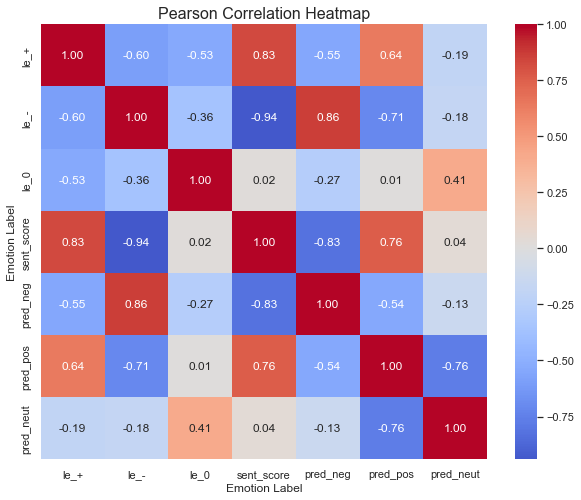

In [69]:
#Create a copy of the df containing only complete rows
df_final_no_null = df_final_dim.dropna()

#Create a list of cols to include in pearsons correlation plot
cols = ['le_+', 'le_-', 'le_0', 'sent_score', 'pred_neg', 'pred_pos', 'pred_neut']

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

In [89]:

# Load the pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

# List of emojis
emojis = ['😭', '💀', '❤️', '🔥', '😃', '💃', '🍫', '😡', 'i love you', 'i hate you', 'can I have some dinner?']

# Process each emoji and get logits
label_names = ['NEG', "NEU", "POS"]
for emoji in emojis:
    inputs = tokenizer(emoji, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    #Apply softmax to calculate probabilities
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    for label, probability in zip(label_names, probabilities):
        print(f"Emoji: {emoji}, Sentiment: {label}, Probability: {probability:.4f}")


Emoji: 😭, Sentiment: NEG, Probability: 0.0459
Emoji: 😭, Sentiment: NEU, Probability: 0.9020
Emoji: 😭, Sentiment: POS, Probability: 0.0521
Emoji: 💀, Sentiment: NEG, Probability: 0.0459
Emoji: 💀, Sentiment: NEU, Probability: 0.9020
Emoji: 💀, Sentiment: POS, Probability: 0.0521
Emoji: ❤️, Sentiment: NEG, Probability: 0.0632
Emoji: ❤️, Sentiment: NEU, Probability: 0.9142
Emoji: ❤️, Sentiment: POS, Probability: 0.0226
Emoji: 🔥, Sentiment: NEG, Probability: 0.0459
Emoji: 🔥, Sentiment: NEU, Probability: 0.9020
Emoji: 🔥, Sentiment: POS, Probability: 0.0521
Emoji: 😃, Sentiment: NEG, Probability: 0.0459
Emoji: 😃, Sentiment: NEU, Probability: 0.9020
Emoji: 😃, Sentiment: POS, Probability: 0.0521
Emoji: 💃, Sentiment: NEG, Probability: 0.0459
Emoji: 💃, Sentiment: NEU, Probability: 0.9020
Emoji: 💃, Sentiment: POS, Probability: 0.0521
Emoji: 🍫, Sentiment: NEG, Probability: 0.0459
Emoji: 🍫, Sentiment: NEU, Probability: 0.9020
Emoji: 🍫, Sentiment: POS, Probability: 0.0521
Emoji: 😡, Sentiment: NEG, Proba

In [92]:
#Testing another model (initial test)
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# List of emojis
emojis = ['😭', '💀', '❤️', '🔥', '😃', '💃', '🍫', '😡', 'i love you', 'i hate you', 'can I have some dinner?']

# Create the sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Perform sentiment analysis for each emoji
results = []
for emoji in emojis:
    result = classifier(emoji)
    results.append(result)

# Print the results
for emoji, result in zip(emojis, results):
    print(f"Emoji: {emoji}")
    for sentiment in result:
        label = sentiment['label']
        score = sentiment['score']
        print(f"Sentiment: {label}, Score: {score}")
    print()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Emoji: 😭
Sentiment: neutral, Score: 0.3935467600822449

Emoji: 💀
Sentiment: neutral, Score: 0.4813096225261688

Emoji: ❤️
Sentiment: positive, Score: 0.8756881356239319

Emoji: 🔥
Sentiment: positive, Score: 0.7973113656044006

Emoji: 😃
Sentiment: positive, Score: 0.7652463912963867

Emoji: 💃
Sentiment: positive, Score: 0.8023108839988708

Emoji: 🍫
Sentiment: neutral, Score: 0.6605011224746704

Emoji: 😡
Sentiment: negative, Score: 0.7813958525657654

Emoji: i love you
Sentiment: positive, Score: 0.8294013142585754

Emoji: i hate you
Sentiment: negative, Score: 0.7887635827064514

Emoji: can I have some dinner?
Sentiment: neutral, Score: 0.8712118864059448



In [93]:
#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[0]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_neg_1'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_neg_1
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.018023
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,0.178246
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.035380
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.034758
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,0.084088


In [94]:
#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[2]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_pos_1'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_neg_1,pred_pos_1
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.018023,0.468608
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,0.178246,0.058924
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.035380,0.659888
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.034758,0.153761
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,0.084088,0.079644


In [95]:
#Function to calculate probabilities for label 0
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()  # Apply softmax to calculate probabilities
    return probabilities[1]  # Probability for label 0 (negative sentiment)

# Generate probabilities and create 'pred_neg' column
df_final_dim['pred_neut_1'] = df_final_dim['emoji'].apply(calculate_probabilities)

# Print the updated DataFrame
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_neg_1,pred_pos_1,pred_neut_1
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.018023,0.468608,0.513369
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,0.178246,0.058924,0.762830
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.035380,0.659888,0.304732
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.034758,0.153761,0.811481
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,0.084088,0.079644,0.836268


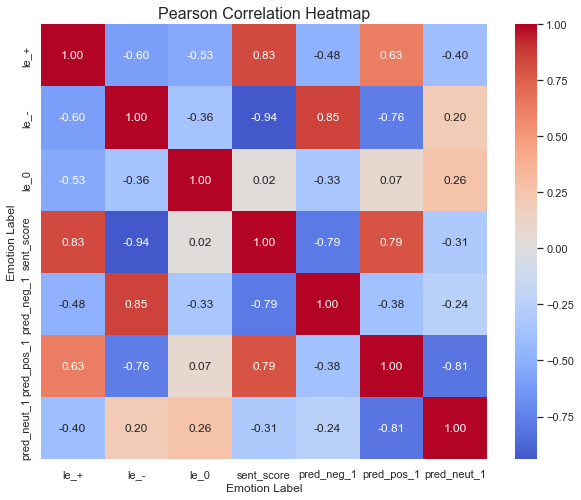

In [96]:
#Create a copy of the df containing only complete rows
df_final_no_null = df_final_dim.dropna()

#Create a list of cols to include in pearsons correlation plot
cols = ['le_+', 'le_-', 'le_0', 'sent_score', 'pred_neg_1', 'pred_pos_1', 'pred_neut_1']

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

In [97]:
#First option outperformed the second- use that as the base
df_final_dim = df_final_dim.drop(columns=['pred_neg_1', 'pred_pos_1', 'pred_neut_1'])
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231


In [146]:
#Add in sent score column
df_final_dim['pred_sent_score'] = (df_final_dim['pred_neg'] * -1) + (df_final_dim['pred_neut'] * 0) + (df_final_dim['pred_pos'] * 1)
df_final_dim.head()

,index,emoji,le_+,le_-,le_0,sent_score,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_sent_score
0,0,🇸🇰,NaN,NaN,NaN,NaN,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.092526
1,1,👔,NaN,NaN,NaN,NaN,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,-0.217531
2,2,🌀,NaN,NaN,NaN,NaN,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.322716
3,3,🚾,NaN,NaN,NaN,NaN,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.108159
4,4,👹,NaN,NaN,NaN,NaN,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,-0.013007


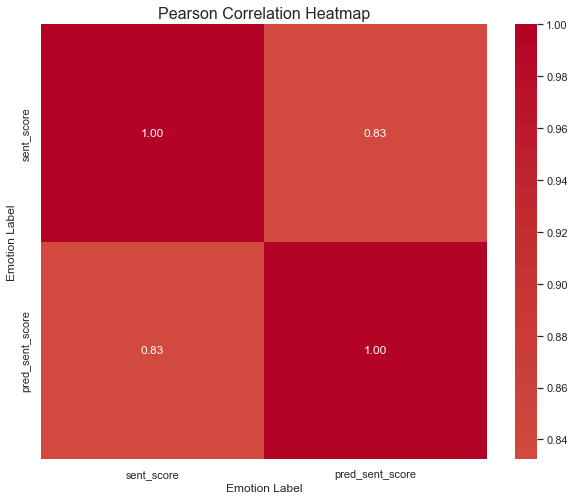

In [147]:
#Compare sentiment score correlation

#Create a list of cols to include in pearsons correlation plot
cols = ['sent_score', 'pred_sent_score']

#Calculate Pearson correlation coefficients
correlation_matrix = df_final_dim[cols].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

In [150]:
#Drop cols that are no longer needed
df_final_dim = df_final_dim.drop(columns=['le_+', 'le_-', 'le_0', 'sent_score', 'index'])
df_final_dim.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_sent_score
0,🇸🇰,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.092526
1,👔,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,-0.217531
2,🌀,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.322716
3,🚾,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.108159
4,👹,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,-0.013007


In [151]:
#Save the df from here as csv for later use
df_final_dim.to_csv('emoji_emotion_stats_all.csv', index=False)